In [3]:
import numpy as np
import pandas as pd
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingClassifier

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# Displaying all columns and rows 
pd.options.display.max_columns = 10000
pd.options.display.max_rows = 10000000

# 1. Importing Data

In [20]:
train = pd.read_csv("train.csv") 
valid = pd.read_csv("validation.csv") 

In [8]:
train.head()

,click,weekday,hour,bidid,userid,useragent,IP,region,city,adexchange,domain,url,urlid,slotid,slotwidth,slotheight,slotvisibility,slotformat,slotprice,creative,bidprice,payprice,keypage,advertiser,usertag
0,0,5,22,b7bea80521fdecd95d2d761a38c91c3f09618066,2e880fb7d690cf7377b2e42e701728e3f3c0e4c1,windows_ie,125.37.175.*,2,2,2.0,trqRTvKaXTKfgg24JKTI,6447a7dfa30fe6eb410c91860e7c9b45,NaN,2015392487,200,200,2,0,5,a4f763f78ef3eedfe614263b94a8924e,238,5,0f951a030abdaedd733ee8d114ce2944,3427,NaN
1,0,1,20,4f51205475678f5a124bc76b2c54163bf8eaa7eb,3a1fe01360ff8100e7d006b83b77a3e4c01d928c,windows_chrome,171.36.92.*,238,239,1.0,20fc675468712705dbf5d3eda94126da,3ddf173a94bd23c326683b6373c75dd4,NaN,mm_10982364_973726_8930541,300,250,FourthView,Na,0,10722,294,23,NaN,2821,NaN
2,0,3,13,b604e3fd054a658ab7ced4285ebf2ef54d2bd890,801d18a056b6fe6b06a794aef17fb0d6daff2414,windows_ie,59.46.106.*,40,41,2.0,trqRTJn7O95I1mKYUV,625d1b5916ea925332c7b326c0574cfa,NaN,1720123646,250,250,2,0,5,798b2d49952d77f1eace9f23c210d0b5,238,24,0f951a030abdaedd733ee8d114ce2944,3427,"10052,10006,13866,10110"
3,0,6,23,0348beeae93e561584c3b50fc9e7746a33048ad7,0d6eaf2259699990e38a1fc5116f112070b9ecdc,windows_ie,114.250.226.*,1,1,1.0,5F97t5E0BTK7XhNrUMpENpn,dedc488b98ca20707bc9a723957e7d1f,NaN,mm_10027070_118039_10308280,160,600,2,1,0,cb7c76e7784031272e37af8e7e9b062c,300,25,bebefa5efe83beee17a3d245e7c5085b,1458,"13866,10063,10111"
4,0,5,6,268149c1789bce2bc9798ffd97ec431219bafeb3,a239d9bb642460d974ba67f85e63b8d3e214da0e,windows_ie,183.63.192.*,216,233,2.0,13625cb070ffb306b425cd803c4b7ab4,4199d1227c511fc776b76594dabff9f8,NaN,1120200150,728,90,OtherView,Na,133,7330,277,133,NaN,2259,NaN


In [9]:
#train.shape

In [10]:
#valid.head()

In [11]:
#valid.shape

Testing set does not have click, bidprice and payprice

# 2. Data Pre-Processing

In [12]:
def preprocess(data, enforce_cols=None):
    ############### Handling useragent ################
    useragent_data= data['useragent'].str.split("_", n = 1, expand = True) 
    data['agent']= useragent_data[0] 
    data['browser']= useragent_data[1] 
    data.drop(columns =['useragent'], inplace = True) 
    
    ############# Computing a New Varialbe: slotsize ###############
    data['slotsize']=data.slotwidth*data.slotheight
    
    ############# Computing New Categorical Variables ###############
    data.ix[data.hour.between(0, 3), 'hour_'] = 1
    data.ix[data.hour.between(4, 7), 'hour_'] = 2
    data.ix[data.hour.between(8, 11), 'hour_'] = 3
    data.ix[data.hour.between(12, 15), 'hour_'] = 4
    data.ix[data.hour.between(16, 19), 'hour_'] = 5
    data.ix[data.hour.between(20, 23), 'hour_'] = 6
    data['hour_'] = data['hour_'].astype(np.uint8)
    
    data.ix[data.slotprice.between(0, 18), 'slotprice_'] = 1
    data.ix[data.slotprice.between(19, 67), 'slotprice_'] = 2
    data.ix[data.slotprice.between(68, 309), 'slotprice_'] = 3
    data.ix[data.slotprice.between(309, 1000000), 'slotprice_'] = 4
    data['slotprice_'] = data['slotprice_'].astype(np.uint8)
    
    ############## Dummy Coding ####################
    data = data.replace('Na',np.nan)
    data_dummy = pd.get_dummies(data, columns=['weekday','region','city','adexchange',
                                               'slotvisibility','slotformat','keypage',
                                               'advertiser','agent','browser','slotsize','slotprice_','hour_'
                                              ])

    ############# Drop Unwanted Variables ################
    data_dropped = data_dummy.drop(columns=['click','bidid', 'userid', 'IP','domain','url','urlid','slotid','bidprice',
                                            'payprice','slotheight','slotwidth','slotprice','hour','creative'])
    
    ############ Fill in NaNs with 0s #############
    data_na=data_dropped.fillna('0')
    
    ############ Handling usertag ################
    # Create a dataframe spliting usertag into variables and count
    usertag_= data_na.usertag.str.replace(',',' ')
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(usertag_)
    usertag_data = pd.DataFrame(data=X.toarray(), columns=vectorizer.get_feature_names())
    # Combining the usertag dataframe with the original dataframe
    data_final = pd.concat([data_na, usertag_data],sort=True,axis=1)
    data_final = data_final.drop(columns=['usertag'])
    
    ###### Matching the number of variables in the validation set with the training set ######
    #""""Reference: DrivenDataLabs, 2017, BENCHMARK FOR POVER-T TEST - PREDICTING POVERTY
        #url: http://drivendata.co/blog/worldbank-poverty-benchmark/""""
    if enforce_cols is not None:
        drop = np.setdiff1d(data_final.columns, enforce_cols)
        add = np.setdiff1d(enforce_cols, data_final.columns)

        data_final.drop(drop, axis=1, inplace=True)
        data_final = data_final.assign(**{c: 0 for c in add})
    
    print(data_final.shape)
    
    return data_final

In [13]:
train_new = preprocess(train)
valid_new = preprocess(valid,enforce_cols=train_new.columns)
valid_new = valid_new[train_new.columns]

KeyboardInterrupt: 

In [ ]:
#train_new.head()

In [ ]:
#valid_new.head()

In [ ]:
#valid_new.head()

In [ ]:
y = train['click']
y_val = valid['click']

# 3. Train Model

## 3.1 Treating imbalanced data

In [ ]:
# Separate click and unclick
resample_num = pd.to_numeric(train['click'])
resample_data = pd.concat([resample_num, train_new],axis=1)

df_majority = resample_data[resample_data.click==0]
df_minority = resample_data[resample_data.click==1]
 
# Downsample unclick
size=int((len(y)-sum(y))*0.03)
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=size,  # ratio
                                 random_state=1) # reproducible results

# Combine 
downsampled = pd.concat([df_majority_downsampled, df_minority])
 
downsampled.click.value_counts()

In [ ]:
# Separate into features and target variable
y_new = downsampled.click
x_new = downsampled.drop('click', axis=1)

In [11]:
#print(y_new.shape)
#print(x_new.shape)

## 3.2 Logistic Regression

In [16]:
best_LR = LogisticRegression(penalty='l1', C=0.1, class_weight='unbalanced', random_state=3, solver='saga')

best_LR.fit(x_new, y_new)

y_valid_p = best_LR.predict_proba(valid_new)
print('Area Under ROC Curve:',round(roc_auc_score(y_val, y_valid_p[:,1]),3))

Area Under ROC Curve: 0.826


In [ ]:
#average CTR
avgCTR = sum(y)/len(y)

#validation pCTR
pCTR_valid_before = y_valid_p[:,1]
pCTR_valid = pCTR_valid_before / (pCTR_valid_before +(1-pCTR_valid_before)/0.03)

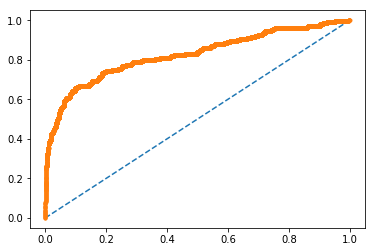

In [17]:
fpr, tpr, thresholds = roc_curve(y_val, y_valid_p[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

# 4. Bidding

## 4.1 Bidding Mechanism

In [18]:
def bidding(bidprice):
    budget = 6250
    imps = 0
    click = 0
    for i in range(0, len(valid)):
        if budget < valid.payprice[i]/1000:
            continue
        if bidprice[i] >= valid.payprice[i]:
            budget = budget - valid.payprice[i]/1000
            imps += 1
            if valid.click[i]==1:
                click += 1
    
    click = click
    imps = imps
    CTR = click/imps
    spend = 6250-budget
    CPM = spend/imps
    eCPC = spend/click
    
    return click, imps, spend, CTR, CPM, eCPC

## 4.2 LR+Non-Linear Bidding Strategies

### 4.2.1 LR + Optimal Real-Time Bidding (ORTB)

In [29]:
ORTB = pd.DataFrame(columns = ['c0', 'lambda0', 'Imps', 'Spend', 'Click'])

c0 = 0
lambda0 = 0
lambda_domain = [1e-8, 5e-8, 1e-7, 5e-7, 1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4]
iteration = 0
max_num = 0

for c in np.arange(4,25,2):
    for m in lambda_domain:
        iteration += 1
        bid = np.sqrt(c * pCTR_valid / m + c*c) - c
        
        click, imps, spend, CTR, CPM, eCPC = bidding(bid)
        
        if click > max_num:
                max_num = click
                lambda0 = m
                c0 = c
                
        ORTB.loc[iteration,'Imps'] = imps
        ORTB.loc[iteration,'c0'] = c0
        ORTB.loc[iteration,'lambda0'] = lambda0
        ORTB.loc[iteration,'Click'] = click
        ORTB.loc[iteration,'Spend'] = round(spend,2)
        ORTB.loc[iteration,'CTR'] = round(CTR,5)
        ORTB.loc[iteration,'CPM'] = round(CPM*1000,2)
        ORTB.loc[iteration,'eCPC'] = round(eCPC,2)

In [30]:
ORTB.head()

,c0,lambda0,Imps,Spend,Click,CTR,CPM,eCPC
1,4.0,1e-08,82852.0,6250.00,54.0,0.00065,75.44,115.74
2,4.0,5e-08,96771.0,6250.00,64.0,0.00066,64.59,97.66
3,4.0,1e-07,110346.0,6250.00,81.0,0.00073,56.64,77.16
4,4.0,5e-07,124285.0,4737.70,137.0,0.00110,38.12,34.58
5,4.0,5e-07,79943.0,2183.83,112.0,0.00140,27.32,19.50


In [31]:
ORTB.iloc[np.where(ORTB.Click == ORTB.Click.max())[0]]

,c0,lambda0,Imps,Spend,Click,CTR,CPM,eCPC
45,12.0,1e-06,140802.0,5932.29,148.0,0.00105,42.13,40.08


### 4.2.2 LR + Quadratic bidding

In [32]:
Qaud = pd.DataFrame(columns=['Base_bid','Imps','Spend','Click'])

iteration = 0
for i in np.arange(3,300,3):
    iteration += 1
    base_bid = i
    #Non-linear strategy inputs to get bid price 
    bid = base_bid * (pCTR_valid / avgCTR)**2
    #bidding mechanism
    click, imps, spend, CTR, CPM, eCPC = bidding(bid)
    #feeding data into a dataframe
    Qaud.loc[iteration,'Base_Bid'] = base_bid
    Qaud.loc[iteration,'Imps'] = imps
    Qaud.loc[iteration,'Click'] = click
    Qaud.loc[iteration,'Spend'] = round(spend,2)
    Qaud.loc[iteration,'CTR'] = round(CTR,5)
    Qaud.loc[iteration,'CPM'] = round(CPM*1000,2)
    Qaud.loc[iteration,'eCPC'] = round(eCPC,2)

In [33]:
Qaud.head()

,Base_bid,Imps,Spend,Click,Base_Bid,CTR,CPM,eCPC
1,NaN,9305.0,535.03,84.0,3.0,0.00903,57.50,6.37
2,NaN,13546.0,805.95,95.0,6.0,0.00701,59.50,8.48
3,NaN,17165.0,1017.88,102.0,9.0,0.00594,59.30,9.98
4,NaN,20604.0,1208.14,108.0,12.0,0.00524,58.64,11.19
5,NaN,23913.0,1387.2,114.0,15.0,0.00477,58.01,12.17


In [34]:
Qaud.iloc[np.where(Qaud.Click == Qaud.Click.max())[0]]

,Base_bid,Imps,Spend,Click,Base_Bid,CTR,CPM,eCPC
38,NaN,107740.0,6240.89,155.0,114.0,0.00144,57.93,40.26


### 4.2.3 LR + Exponential bidding

In [35]:
Exp = pd.DataFrame(columns=['Base_bid','Imps','Spend','Click'])

iteration = 0
for i in np.arange(3,303,3):
    iteration += 1
    base_bid = i
    #Non-linear strategy inputs to get bid price 
    bid = base_bid * np.exp(pCTR_valid/avgCTR)
    #bidding mechanism
    click, imps, spend, CTR, CPM, eCPC = bidding(bid)
    #feeding data into a dataframe
    Exp.loc[iteration,'Base_Bid'] = base_bid
    Exp.loc[iteration,'Imps'] = imps
    Exp.loc[iteration,'Click'] = click
    Exp.loc[iteration,'Spend'] = round(spend,2)
    Exp.loc[iteration,'CTR'] = round(CTR,5)
    Exp.loc[iteration,'CPM'] = round(CPM*1000,2)
    Exp.loc[iteration,'eCPC'] = round(eCPC,2)

In [36]:
Exp.head()

,Base_bid,Imps,Spend,Click,Base_Bid,CTR,CPM,eCPC
1,NaN,18047.0,991.62,101.0,3.0,0.00560,54.95,9.82
2,NaN,31152.0,1339.52,113.0,6.0,0.00363,43.00,11.85
3,NaN,43056.0,1704.18,116.0,9.0,0.00269,39.58,14.69
4,NaN,58930.0,2193.75,125.0,12.0,0.00212,37.23,17.55
5,NaN,75249.0,2745.7,133.0,15.0,0.00177,36.49,20.64


In [37]:
Exp.iloc[np.where(Exp.Click == Exp.Click.max())[0]]

,Base_bid,Imps,Spend,Click,Base_Bid,CTR,CPM,eCPC
10,NaN,142777.0,6215.73,158.0,30.0,0.00111,43.53,39.34


## 4.3 Gradient Boosting Classifier (GBC) + Non-Linear Bidding Strategies

In [ ]:
gbc = ensemble.GradientBoostingClassifier(**{'n_estimators': 250, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.05, 'loss': 'deviance'})
gbc.fit(x_new, y_new)
pred_y_gbc = gbc.predict_proba(valid_new)

In [ ]:
auc1=roc_auc_score(y_val, pred_y_gbc[:,1])

In [22]:
print(auc1)

0.8802152091227731


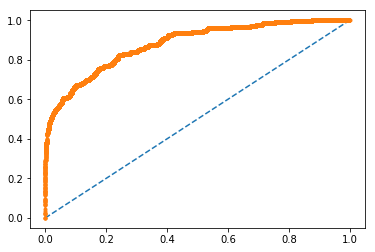

In [23]:
fpr, tpr, thresholds = roc_curve(y_val, pred_y_gbc[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
#plt.savefig('Q4.png',dpi=300)
plt.show()

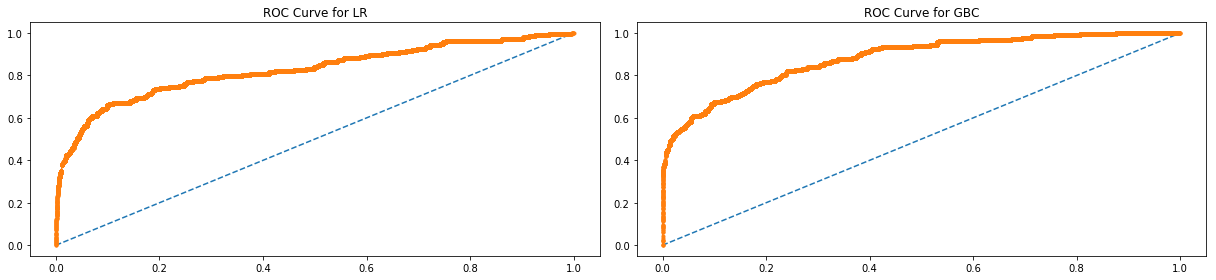

In [24]:
fig, (ax1, ax2)=plt.subplots(1,2,figsize=(17,4))

fpr, tpr, thresholds = roc_curve(y_val, y_valid_p[:,1])
ax1.plot([0, 1], [0, 1], linestyle='--')
ax1.plot(fpr, tpr, marker='.')
ax1.set_title("ROC Curve for LR")

fpr1, tpr1, thresholds1 = roc_curve(y_val, pred_y_gbc[:,1])
ax2.plot([0, 1], [0, 1], linestyle='--')
ax2.plot(fpr1, tpr1, marker='.')
ax2.set_title("ROC Curve for GBC")
plt.savefig('ROC ALL.png',dpi=300)
plt.tight_layout()

In [ ]:
#average CTR
avgCTR = sum(y)/len(y)

#validation pCTR
pCTR_valid_gbc_before = pred_y_gbc[:,1]
pCTR_valid_gbc = pCTR_valid_gbc_before / (pCTR_valid_gbc_before +(1-pCTR_valid_gbc_before)/0.03)

### 4.3.1 GBC + ORTB

In [44]:
ORTB1 = pd.DataFrame(columns = ['c0', 'lambda0', 'Imps', 'Spend', 'Click'])

c0 = 0
lambda0 = 0
lambda_domain = [1e-8, 5e-8, 1e-7, 5e-7, 1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4]
iteration = 0
max_num = 0

for c in np.arange(4,25,2):
    for m in lambda_domain:
        iteration += 1
        bid = np.sqrt(c * pCTR_valid_gbc / m + c*c) - c
        
        click, imps, spend, CTR, CPM, eCPC = bidding(bid)
        
        if click > max_num:
                max_num = click
                lambda0 = m
                c0 = c
                
        ORTB1.loc[iteration,'Imps'] = imps
        ORTB1.loc[iteration,'c0'] = c0
        ORTB1.loc[iteration,'lambda0'] = lambda0
        ORTB1.loc[iteration,'Click'] = click
        ORTB1.loc[iteration,'Spend'] = round(spend,2)
        ORTB1.loc[iteration,'CTR'] = round(CTR,5)
        ORTB1.loc[iteration,'CPM'] = round(CPM*1000,2)
        ORTB1.loc[iteration,'eCPC'] = round(eCPC,2)

In [45]:
ORTB1.head()

,c0,lambda0,Imps,Spend,Click,CTR,CPM,eCPC
1,4.0,1e-08,80761.0,6250.00,52.0,0.00064,77.39,120.19
2,4.0,5e-08,99935.0,6250.00,66.0,0.00066,62.54,94.70
3,4.0,1e-07,116465.0,6250.00,84.0,0.00072,53.66,74.40
4,4.0,5e-07,107294.0,3352.30,137.0,0.00128,31.24,24.47
5,4.0,5e-07,72738.0,1711.47,111.0,0.00153,23.53,15.42


In [46]:
ORTB1.iloc[np.where(ORTB1.Click == ORTB1.Click.max())[0]]

,c0,lambda0,Imps,Spend,Click,CTR,CPM,eCPC
95,22.0,1e-06,149664.0,6145.41,162.0,0.00108,41.06,37.93


### 4.3.2 GBC + Quadratic

In [47]:
Qaud1 = pd.DataFrame(columns=['Base_bid','Imps','Spend','Click'])

iteration = 0
for i in np.arange(3,300,3):
    iteration += 1
    base_bid = i
    #Non-linear strategy inputs to get bid price 
    bid = base_bid * (pCTR_valid_gbc/ avgCTR)**2
    #bidding mechanism
    click, imps, spend, CTR, CPM, eCPC = bidding(bid)
    #feeding data into a dataframe
    Qaud1.loc[iteration,'Base_Bid'] = base_bid
    Qaud1.loc[iteration,'Imps'] = imps
    Qaud1.loc[iteration,'Click'] = click
    Qaud1.loc[iteration,'Spend'] = round(spend,2)
    Qaud1.loc[iteration,'CTR'] = round(CTR,5)
    Qaud1.loc[iteration,'CPM'] = round(CPM*1000,2)
    Qaud1.loc[iteration,'eCPC'] = round(eCPC,2)

In [48]:
Qaud1.head()

,Base_bid,Imps,Spend,Click,Base_Bid,CTR,CPM,eCPC
1,NaN,6882.0,340.57,92.0,3.0,0.01337,49.49,3.70
2,NaN,9670.0,515.99,100.0,6.0,0.01034,53.36,5.16
3,NaN,11627.0,632.75,107.0,9.0,0.00920,54.42,5.91
4,NaN,13769.0,747.86,110.0,12.0,0.00799,54.31,6.80
5,NaN,15860.0,860.43,114.0,15.0,0.00719,54.25,7.55


In [49]:
Qaud1.iloc[np.where(Qaud1.Click == Qaud1.Click.max())[0]]

,Base_bid,Imps,Spend,Click,Base_Bid,CTR,CPM,eCPC
72,NaN,105933.0,5929.48,161.0,216.0,0.00152,55.97,36.83
73,NaN,106988.0,5995.05,161.0,219.0,0.00150,56.03,37.24
74,NaN,107946.0,6059.23,161.0,222.0,0.00149,56.13,37.63
75,NaN,108906.0,6124,161.0,225.0,0.00148,56.23,38.04
76,NaN,109844.0,6191,161.0,228.0,0.00147,56.36,38.45
77,NaN,110736.0,6250,161.0,231.0,0.00145,56.44,38.82


### 4.3.3 GBC + Exponential

In [50]:
Exp1 = pd.DataFrame(columns=['Base_bid','Imps','Spend','Click'])

iteration = 0
for i in np.arange(3,303,3):
    iteration += 1
    base_bid = i
    #Non-linear strategy inputs to get bid price 
    bid = base_bid * np.exp(pCTR_valid_gbc/avgCTR)
    #bidding mechanism
    click, imps, spend, CTR, CPM, eCPC = bidding(bid)
    #feeding data into a dataframe
    Exp1.loc[iteration,'Base_Bid'] = base_bid
    Exp1.loc[iteration,'Imps'] = imps
    Exp1.loc[iteration,'Click'] = click
    Exp1.loc[iteration,'Spend'] = round(spend,2)
    Exp1.loc[iteration,'CTR'] = round(CTR,5)
    Exp1.loc[iteration,'CPM'] = round(CPM*1000,2)
    Exp1.loc[iteration,'eCPC'] = round(eCPC,2)

In [51]:
Exp1.head()

,Base_bid,Imps,Spend,Click,Base_Bid,CTR,CPM,eCPC
1,NaN,12740.0,619.26,108.0,3.0,0.00848,48.61,5.73
2,NaN,24441.0,858.86,112.0,6.0,0.00458,35.14,7.67
3,NaN,33979.0,1108.26,118.0,9.0,0.00347,32.62,9.39
4,NaN,44676.0,1397.52,123.0,12.0,0.00275,31.28,11.36
5,NaN,60523.0,1820.41,134.0,15.0,0.00221,30.08,13.59


In [52]:
Exp1.iloc[np.where(Exp1.Click == Exp1.Click.max())[0]]

,Base_bid,Imps,Spend,Click,Base_Bid,CTR,CPM,eCPC
12,NaN,140031.0,5572.55,158.0,36.0,0.00113,39.8,35.27


## ---------------- GBC+Cubic -----------------

In [56]:
S3 = pd.DataFrame(columns = ['Base_Bid','Imps','Click','Spend','CTR','CPM','eCPC'])
iteration = 0
for i in np.arange(20,500,5):
    iteration += 1
    base_bid = i
    #linear strategy inputs to get bid price 
    bid = base_bid * (pCTR_valid_gbc/avgCTR)**3
    #bidding mechanism
    click, imps, spend, CTR, CPM, eCPC = bidding(bid)
    #feeding data into a dataframe
    S3.loc[iteration,'Base_Bid'] = base_bid
    S3.loc[iteration,'Imps'] = imps
    S3.loc[iteration,'Click'] = click
    S3.loc[iteration,'Spend'] = round(spend,2)
    S3.loc[iteration,'CTR'] = round(CTR,5)
    S3.loc[iteration,'CPM'] = round(CPM*1000,2)
    S3.loc[iteration,'eCPC'] = round(eCPC,2)

In [57]:
S3.iloc[np.where(S3.Click == S3.Click.max())[0]]

,Base_Bid,Imps,Click,Spend,CTR,CPM,eCPC
69,360,94530,164,6209.58,0.00173,65.69,37.86
70,365,95112,164,6250,0.00172,65.71,38.11


## -----------------GBC+Fourth Power-------------------

In [58]:
S4 = pd.DataFrame(columns = ['Base_Bid','Imps','Click','Spend','CTR','CPM','eCPC'])
iteration = 0
for i in np.arange(470,900,5):
    iteration += 1
    base_bid = i
    #linear strategy inputs to get bid price 
    bid = base_bid * (pCTR_valid_gbc/avgCTR)**4
    #bidding mechanism
    click, imps, spend, CTR, CPM, eCPC = bidding(bid)
    #feeding data into a dataframe
    S4.loc[iteration,'Base_Bid'] = base_bid
    S4.loc[iteration,'Imps'] = imps
    S4.loc[iteration,'Click'] = click
    S4.loc[iteration,'Spend'] = round(spend,2)
    S4.loc[iteration,'CTR'] = round(CTR,5)
    S4.loc[iteration,'CPM'] = round(CPM*1000,2)
    S4.loc[iteration,'eCPC'] = round(eCPC,2)

In [59]:
S4.iloc[np.where(S4.Click == S4.Click.max())[0]]

,Base_Bid,Imps,Click,Spend,CTR,CPM,eCPC
15,540,85693,163,6138.03,0.0019,71.63,37.66
16,545,85959,163,6157.74,0.0019,71.64,37.78
17,550,86220,163,6178.01,0.00189,71.65,37.9
18,555,86538,163,6205.88,0.00188,71.71,38.07
19,560,86845,163,6230.74,0.00188,71.75,38.23
20,565,87115,163,6249.13,0.00187,71.73,38.34


## ---------------GBC+Fifth Power-------------

In [60]:
S5 = pd.DataFrame(columns = ['Base_Bid','Imps','Click','Spend','CTR','CPM','eCPC'])
iteration = 0
for i in np.arange(570,800,5):
    iteration += 1
    base_bid = i
    #linear strategy inputs to get bid price 
    bid = base_bid * (pCTR_valid_gbc/avgCTR)**5
    #bidding mechanism
    click, imps, spend, CTR, CPM, eCPC = bidding(bid)
    #feeding data into a dataframe
    S5.loc[iteration,'Base_Bid'] = base_bid
    S5.loc[iteration,'Imps'] = imps
    S5.loc[iteration,'Click'] = click
    S5.loc[iteration,'Spend'] = round(spend,2)
    S5.loc[iteration,'CTR'] = round(CTR,5)
    S5.loc[iteration,'CPM'] = round(CPM*1000,2)
    S5.loc[iteration,'eCPC'] = round(eCPC,2)

In [61]:
S5.iloc[np.where(S5.Click == S5.Click.max())[0]]

,Base_Bid,Imps,Click,Spend,CTR,CPM,eCPC
43,780,80002,160,6040.57,0.002,75.51,37.75
44,785,80173,160,6053.32,0.002,75.5,37.83
45,790,80320,160,6065.72,0.00199,75.52,37.91
46,795,80473,160,6076.72,0.00199,75.51,37.98


## --------------GBC+OtherStrategy----------------

In [ ]:
Q51 = pd.DataFrame(columns = ['Base_Bid','Imps','Click','Spend','CTR','CPM','eCPC'])
iteration = 0
for i in np.arange(3000,30000,1000):
    iteration += 1
    base_bid = i
    #linear strategy inputs to get bid price 
    avg = np.mean(pCTR_valid_gbc)
    bid = base_bid * (pCTR_gbc_array/avg)**3
    #bidding mechanism 
    click, imps, spend, CTR, CPM, eCPC = bidding(bid)
    #feeding data into a dataframe
    Q51.loc[iteration,'Base_Bid'] = base_bid
    Q51.loc[iteration,'Imps'] = imps
    Q51.loc[iteration,'Click'] = click
    Q51.loc[iteration,'Spend'] = round(spend,2)
    Q51.loc[iteration,'CTR'] = round(CTR,5)
    Q51.loc[iteration,'CPM'] = round(CPM*1000,2)
    Q51.loc[iteration,'eCPC'] = round(eCPC,2)
    print('Iteration',iteration,'/',(500-20)/5,': Click = ',click, '| Base_bid = ',base_bid, '| Spend = ',spend,
          '| CTR = ',CTR, '| CPM = ', CPM*1000 , '| eCPC = ', eCPC)

## ---------------GBC + Remove Bottom 30% ---------------

In [4]:
p_payprice = pd.read_csv("p_payprice.csv")
pCTR = pd.read_csv("pCTR_valid.csv")
avgCTR = pCTR.mean()
print(avgCTR)
print(np.percentile(pCTR,30))

In [9]:
pCTR_new = pCTR['p'].map(lambda x: 0 if x <0.0002 else np.exp(x))
bid = pCTR_new * p_payprice['valid payprice']
b = bid/ 0.000738
bid = pd.DataFrame(b)
bid.columns = ['pCTR']
bid.head()

In [26]:
kan = pd.DataFrame(columns = ['Base_Bid','Imps','Click','Spend','CTR','CPM','eCPC'])
iteration = 0

for c in np.arange(0.0005,0.3,0.00001):
    iteration += 1
    bidprice =  bid['pCTR'] * c
    
    click, imps, spend, CTR, CPM, eCPC = bidding(bidprice)
    
    kan.loc[iteration,'constant'] = c
    kan.loc[iteration,'Imps'] = imps
    kan.loc[iteration,'Click'] = click
    kan.loc[iteration,'Spend'] = round(spend,2)
    kan.loc[iteration,'CTR'] = round(CTR,5)
    kan.loc[iteration,'CPM'] = round(CPM*1000,2)
    kan.loc[iteration,'eCPC'] = round(eCPC,2)
    print('Iteration',iteration,'/',(300-3)/3,': Click = ',click, '| Constant = ',c, '| Spend = ',spend,
          '| CTR = ',CTR, '| CPM = ', CPM*1000 , '| eCPC = ', eCPC)
    

Iteration 1 / 99.0 : Click =  61 | Constant =  0.0005 | Spend =  2128.710000002192 | CTR =  0.0008720639322935281 | CPM =  30.432314972368324 | eCPC =  34.896885245937575
Iteration 2 / 99.0 : Click =  62 | Constant =  0.00051 | Spend =  2230.3490000021634 | CTR =  0.00086476232983709 | CPM =  31.10841609018862 | eCPC =  35.97337096777683
Iteration 3 / 99.0 : Click =  64 | Constant =  0.0005200000000000001 | Spend =  2327.0860000021066 | CTR =  0.0008723981407014627 | CPM =  31.721023432097525 | eCPC =  36.360718750032916
Iteration 4 / 99.0 : Click =  68 | Constant =  0.0005300000000000001 | Spend =  2421.239000002079 | CTR =  0.0009075015681093273 | CPM =  32.31291454807862 | eCPC =  35.606455882383514
Iteration 5 / 99.0 : Click =  68 | Constant =  0.0005400000000000001 | Spend =  2505.5590000020934 | CTR =  0.0008906002383665344 | CPM =  32.81546239181294 | eCPC =  36.84645588238373
Iteration 6 / 99.0 : Click =  70 | Constant =  0.0005500000000000001 | Spend =  2597.0150000021076 | CT

KeyboardInterrupt: 

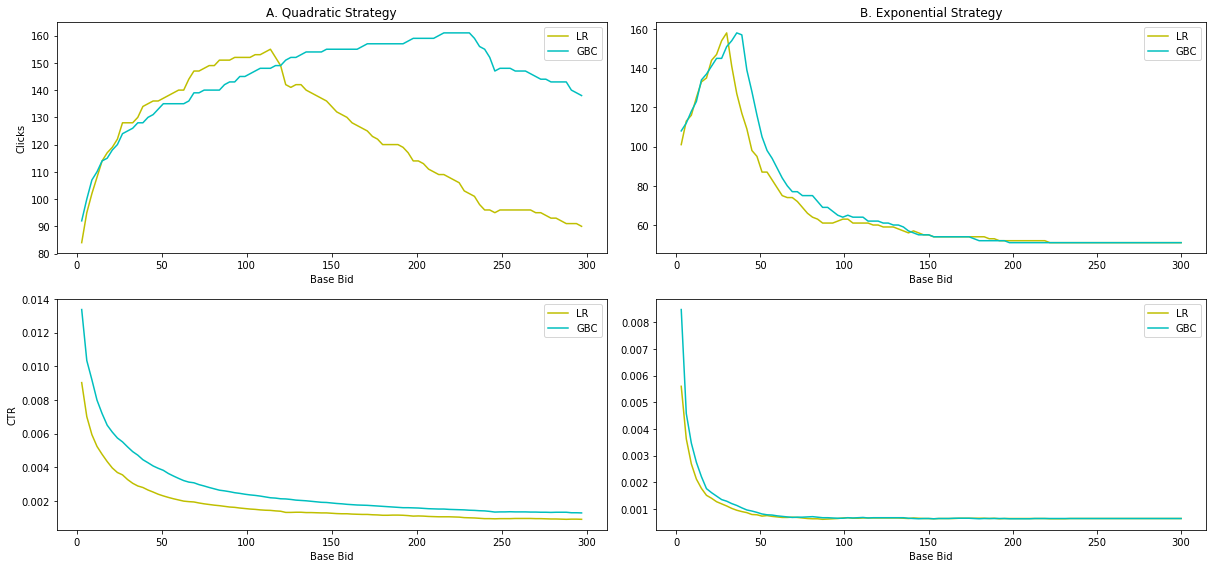

In [63]:
fig, ((ax1, ax2), (ax3, ax4))=plt.subplots(2,2, figsize = (17,8))

ax1.plot(Qaud.Base_Bid,Qaud.Click,color='y',label='LR')
ax1.set_xlabel('Base Bid')
ax1.set_ylabel('Clicks')
ax1.plot(Qaud1.Base_Bid, Qaud1.Click, color='c',label='GBC')
ax1.set_title("A. Quadratic Strategy")
ax1.legend()

ax3.plot(Qaud.Base_Bid,Qaud.CTR,color='y',label='LR')
ax3.set_xlabel('Base Bid')
ax3.set_ylabel('CTR')
ax3.plot(Qaud1.Base_Bid, Qaud1.CTR, color='c',label='GBC')
ax3.legend()
#ax3.set_title("A2. Quadratic Strategy CTR")

ax2.plot(Exp.Base_Bid,Exp.Click,color='y',label='LR')
ax2.set_xlabel('Base Bid')
ax2.plot(Exp1.Base_Bid, Exp1.Click, color='c',label='GBC')
ax2.set_title("B. Exponential Strategy")
ax2.legend()

ax4.plot(Exp.Base_Bid,Exp.CTR,color='y',label='LR')
ax4.set_xlabel('Base Bid')
ax4.plot(Exp1.Base_Bid, Exp1.CTR, color='c',label='GBC')
#ax4.set_title("B2. Exponential Strategy CTR")
ax4.legend()

plt.tight_layout()
plt.savefig('Q4.png',dpi=300)

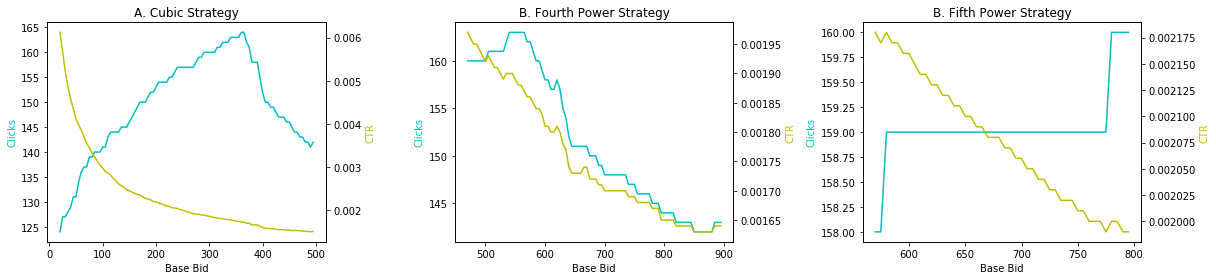

In [65]:
fig, (ax1,ax3,ax5) = plt.subplots(1,3,figsize = (17,4))
ax1.plot(S3.Base_Bid,S3.Click,color='c')
ax1.set_title("A. Cubic Strategy")
ax1.set_xlabel('Base Bid',color='k')
ax1.set_ylabel('Clicks',color='c')

ax2 = ax1.twinx()
ax2.plot(S3.Base_Bid, S3.CTR, color='y')
ax2.set_ylabel('CTR',color='y')

ax3.plot(S4.Base_Bid,S4.Click,color='c')
ax3.set_title("B. Fourth Power Strategy")
ax3.set_xlabel('Base Bid',color='k')
ax3.set_ylabel('Clicks',color='c')

ax4 = ax3.twinx()
ax4.plot(S4.Base_Bid, S4.CTR, color='y')
ax4.set_ylabel('CTR',color='y')

ax5.plot(S5.Base_Bid,S5.Click,color='c')
ax5.set_title("B. Fifth Power Strategy")
ax5.set_xlabel('Base Bid',color='k')
ax5.set_ylabel('Clicks',color='c')

ax6 = ax5.twinx()
ax6.plot(S5.Base_Bid, S5.CTR, color='y')
ax6.set_ylabel('CTR',color='y')

plt.tight_layout()
plt.savefig('Q5 New Strategies.png',dpi=300)